# PatchTST Model Development

In this section we will develop the PatchTST model to predict S&P Close, Dow Jones Close.

## Model Congfiguration 

We will configure the PatchTST model based on the `Economic_Data_1994_2025` dataset we processed

In [2]:
from transformers import PatchTSTConfig, PatchTSTForPrediction, PatchTSTForPretraining
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

/opt/anaconda3/envs/Personal_Proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# For faster development
device = torch.device('mps')
device

device(type='mps')

In [4]:
dataset = pd.read_csv('../data/model_data/Economic_Data_1994-2025.csv')
dataset = dataset.drop(['DATE', 'Unnamed: 0'], axis=1)

## Understanding PatchTST

- **Context Length**

    Context length is how far we look back in total. If we were trying to predict the closing price for the SP500 tomorrow, our context length would be how far we look back to make our prediction.

- **Patch Length**

    Patch length is like a subset of our context length. When looking at our entire context length, patch length is the looking at each individual week up until tomorrow to make our final prediction

- **Patch Stride**

    Patch stride is how far our patch length will move after observing an individual week. We can overlap weeks to see any comparisons.
    
For each batch we will pass N amount of rows. Each row has previous rows (context length) attached to it. For each row & it's context length we pass it into our model to train on. During the training process we will used. masked forecasting. This will mask the last portion of our patch's for the model to predict. It then check's it's guesses and updates its weights accordingly.

## PreTraining Model

The pre-training model will learn ***every*** column in our dataset from all dates. This will help the model develop relationships between all variables. 

In [5]:
# How many features we are including 
NUM_INPUT = len(dataset.columns)

# Batch size for training
BATCH_SIZE = 16

# For What we are predicting
NUM_TARGET = 2

# How many steps we take in the context length
CONTEXT_LEN = 120

# How many steps we take in the context length
PATCH_LEN = 20

# How far we predict into the future:
PRED_LEN = 10

# How far we move our patch length
PATCH_STRD = int(PATCH_LEN * .35)

# How our model is trained
MASK_TYPE = 'forecast'

# Dimension of the model's internal representations
D_MODEL = 256

# Number of transformer encoder layers (should be multiple of d_model)
# When increased should increase path_dropout.
# default: 3
NUM_HIDD_LAYERS = 4

# Number of parallel attention mechanisms, allows model to focus on different temporal patterns simultaneously (4-8) ideal range
# should divide d model evenly 
#
# larger d_model and more attention heads benefit from higher dropout rates
# default: 4
NUM_ATT_HEAD = 8

# Prevent overfitting by randomly deactivating components, acts as regularization during training
ATT_DROP = .1

# Applies dropout to the feed-forward networks within transformer blocks, 
FF_DROP = .2

# Randomly skips entire layers or sub-pathways during training
# rule of thumb (num_hidden_layers - 2) * .05
PATH_DROP = (NUM_HIDD_LAYERS - 2) * .05

# How many items are masked in our forcast
NUM_PATCH = [int(BATCH_SIZE * .4)] # 20% of our batch

# Configuring Model
pretrain_config = PatchTSTConfig(
    num_input_channels = NUM_INPUT,
    context_length = CONTEXT_LEN,
    patch_length = PATCH_LEN,
    stride = PATCH_STRD,
    mask_type='forecast',
    num_forecast_mask_patches = NUM_PATCH,
    do_mask_input=True,
    prediction_length=PRED_LEN,
    d_model=D_MODEL,
    num_hidden_layers=NUM_HIDD_LAYERS,
    num_attention_heads=NUM_ATT_HEAD,
    attention_dropout=ATT_DROP,
    ff_dropout=FF_DROP,
    path_dropout=PATH_DROP,
)

pretrain_model = PatchTSTForPretraining(pretrain_config)

Here we are splitting up our data into 2 portions. A `test` set and a `train` set. The test set is used to evalute our model based on training from the train set

We split it 80/10/10, where 80% of our data is training data, and 10% of our data is testing, and 10% is validation for each epoch.

In [6]:
# Set up constraints for development
num_train = int(len(dataset) * .7)
num_test = int(len(dataset) * .2)
num_val = int(len(dataset) * .1)

# Breaking up the data into train/test sets.
train = dataset[0: num_train]
test = dataset[num_train:num_test + num_train]
val = dataset[num_test+num_train:(num_test+num_train) + num_val]

This portion here grabs context windows for all rows in our train/test sets

In [7]:
# Creates a context window for each data point to feed into the model during training
def create_sequence_windows(data, window_size):
    windows = []
    
    # We start in the dataFrame at an index 'window_size' and look back depending on the window size
    # We will grab a context window for all data points
    for i in range(len(data) - window_size + 1):
        windows.append(data.iloc[i:i+window_size].values)
    return np.array(windows)

train_windows = create_sequence_windows(train, CONTEXT_LEN)
test_windows = create_sequence_windows(test, CONTEXT_LEN)
val_windows = create_sequence_windows(val, CONTEXT_LEN)

In [8]:
# Puts our data in PyTorch tensors for proper data types during training
past_values_train = torch.tensor(train_windows, dtype=torch.float32)
past_values_test = torch.tensor(test_windows, dtype=torch.float32)
past_values_val = torch.tensor(val_windows, dtype=torch.float32)

Preparing our data to be passed into our model for pre training

In [9]:
# Puts the tensors in a dataset for the dataloader to properly use
data_train = TensorDataset(past_values_train)

# Divides our data into batches based on the BATCH_SIZE
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

data_test = TensorDataset(past_values_test)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE)

data_val = TensorDataset(past_values_val)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE)

In [10]:
pretrain_model = pretrain_model.to(device)

### Pre-Training

Here we are training our model by doing the following:

1. Divide Training into Epoch
    - For each epoch we:
        - Set model to train mode
        - Pass in all of our data one batch size at a time
        - After training on a patch we update our parameters
        - Put our model into evaluation mode
        - Test on our validation set and print results to output
2. Final Train
    - Once we pass through all epochs we do a final test on our
        never seen data, `test` set. 
    - We iterate through our data one batch size at a time and evaluate the model
        one last time

In [11]:
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=.001)

epochs = 10


for epoch in range(epochs):

    # Allows for progress bar during training per epoch
    loop = tqdm(dataloader_train, leave=True)
    losses = []
    
    for batch in loop:
        
        # Puts model in train mode
        pretrain_model.train()
        
        # Clears any previous gradient calculations
        optimizer.zero_grad()
        
        # Transfers batch onto GPU for faster processing
        past_values = batch[0].to(device)
        
        # Foward pass through our model, generates predictions
        outputs = pretrain_model(past_values=past_values)
        
        # Get's the loss for our predictions (how far off our predictions were)
        loss = outputs.loss
        
        # Calculates which weights contributed to the error of our prediction
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(pretrain_model.parameters(), max_norm=3.0)
        
        # Updates the optimizer based on the calculations made from loss.backward()
        optimizer.step()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
    
    print("Mean Training Loss", np.mean(losses))
        
    pretrain_model.eval()
    losses = []

    loop = tqdm(dataloader_val, leave=True)
    
    for batch in loop:
        pretrain_model.eval()
        
        past_values = batch[0].to(device)
        
        outputs = pretrain_model(past_values=past_values)
        
        loss = outputs.loss
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
        
    print(f"Mean Training Loss for validation set on EPOCH {epoch} : {np.mean(losses)}")

pretrain_model.eval()
losses = []

loop = tqdm(dataloader_test, leave=True)

for batch in loop:
    
    past_values = batch[0].to(device)
    
    outputs = pretrain_model(past_values=past_values)
    
    loss = outputs.loss
    
    loop.set_description(f'Test')
    loop.set_postfix(loss=loss.item())
    losses.append(loss.item())
    
print(f"Mean Training Loss for test set : {np.mean(losses)}")

  0%|          | 0/335 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 335/335 [04:27<00:00,  1.25it/s, loss=0.0769]


Mean Training Loss 0.1480788578960433


Epoch 0: 100%|██████████| 42/42 [00:08<00:00,  4.84it/s, loss=0.0879]


Mean Training Loss for validation set on EPOCH 0 : 0.09393673789288316


Epoch 1: 100%|██████████| 335/335 [04:25<00:00,  1.26it/s, loss=0.0491]


Mean Training Loss 0.065046928689551


Epoch 1: 100%|██████████| 42/42 [00:08<00:00,  4.93it/s, loss=0.0417]


Mean Training Loss for validation set on EPOCH 1 : 0.04813251582284769


Epoch 2: 100%|██████████| 335/335 [04:26<00:00,  1.26it/s, loss=0.0585]


Mean Training Loss 0.045247424922105095


Epoch 2: 100%|██████████| 42/42 [00:08<00:00,  4.94it/s, loss=0.0804]


Mean Training Loss for validation set on EPOCH 2 : 0.07140913233160973


Epoch 3: 100%|██████████| 335/335 [04:26<00:00,  1.26it/s, loss=0.0291]


Mean Training Loss 0.038385463066732704


Epoch 3: 100%|██████████| 42/42 [00:08<00:00,  4.70it/s, loss=0.0307]


Mean Training Loss for validation set on EPOCH 3 : 0.02952000086328813


Epoch 4: 100%|██████████| 335/335 [04:25<00:00,  1.26it/s, loss=0.029] 


Mean Training Loss 0.03187815896721918


Epoch 4: 100%|██████████| 42/42 [00:08<00:00,  4.96it/s, loss=0.04]  


Mean Training Loss for validation set on EPOCH 4 : 0.040865891391322726


Epoch 5: 100%|██████████| 335/335 [04:25<00:00,  1.26it/s, loss=0.0323]


Mean Training Loss 0.03210745640099048


Epoch 5: 100%|██████████| 42/42 [00:08<00:00,  4.67it/s, loss=0.0302]


Mean Training Loss for validation set on EPOCH 5 : 0.03752407857349941


Epoch 6: 100%|██████████| 335/335 [04:25<00:00,  1.26it/s, loss=0.0236]


Mean Training Loss 0.03229936236765847


Epoch 6: 100%|██████████| 42/42 [00:08<00:00,  4.80it/s, loss=0.054] 


Mean Training Loss for validation set on EPOCH 6 : 0.050138216909198535


Epoch 7: 100%|██████████| 335/335 [04:24<00:00,  1.27it/s, loss=0.0294]


Mean Training Loss 0.028759574887356653


Epoch 7: 100%|██████████| 42/42 [00:08<00:00,  4.97it/s, loss=0.0395]


Mean Training Loss for validation set on EPOCH 7 : 0.036733215231271016


Epoch 8: 100%|██████████| 335/335 [04:24<00:00,  1.27it/s, loss=0.0202]


Mean Training Loss 0.027672830135075013


Epoch 8: 100%|██████████| 42/42 [00:08<00:00,  4.95it/s, loss=0.0441]


Mean Training Loss for validation set on EPOCH 8 : 0.04192496814011108


Epoch 9: 100%|██████████| 335/335 [04:24<00:00,  1.27it/s, loss=0.0288]


Mean Training Loss 0.028575669023305623


Epoch 9: 100%|██████████| 42/42 [00:08<00:00,  4.93it/s, loss=0.031] 


Mean Training Loss for validation set on EPOCH 9 : 0.033252003602683544


Test: 100%|██████████| 91/91 [00:18<00:00,  4.82it/s, loss=0.0205] 

Mean Training Loss for test set : 0.031185404172392336


In [12]:
torch.save(pretrain_model.state_dict(), 'pt_m_2ynorm_v1.bin')

### Model Logs

#### Parameters Set 1 (Not Good)

In [ ]:
NUM_INPUT = len(dataset.columns)
BATCH_SIZE = 16
CONTEXT_LEN = 190
PATCH_LEN = 10
PATCH_STRD = 8
MASK_TYPE = 'forecast'
NUM_PATCH = [int(BATCH_SIZE * .2)]

- **pretrained_model_no_mask** 

    Mean Training Loss for test set : 0.0191

- **pretrained_model_mask** 

    Mean Training Loss for test set : 0.0199


#### Parameters Set 2 (Not Good)

In [ ]:
NUM_INPUT = len(dataset.columns)
BATCH_SIZE = 16
CONTEXT_LEN = 60 # Only looking back 60 days instead of 190
PATCH_LEN = 5 # Look at each prior week before for each data point in context length 
PATCH_STRD = 4 # Move window while keeping the last week's most recent day in set.
MASK_TYPE = 'forecast'
NUM_PATCH = [int(BATCH_SIZE * .2)]

- **pretrained_model_no_mask** 

    Mean Training Loss for test set : 80.5

- **pretrained_model_mask** 

    Mean Training Loss for test set : 1.29

#### Parameter Set 3 (Past Version)

In [ ]:
NUM_INPUT = len(dataset.columns)
BATCH_SIZE = 32 # increase batch
CONTEXT_LEN = 90 # Middle Ground context length
PATCH_LEN = 10 # 2 week patch
PATCH_STRD = 5 # 1 week movement
MASK_TYPE = 'forecast'
NUM_PATCH = [int(BATCH_SIZE * .4)] # 40% of our batch

- **pretrained_model_mask** 

    Mean Training Loss for test set: `.1`

#### Parameter Set 4 (Current Version)

In [ ]:
NUM_INPUT = len(dataset.columns)
BATCH_SIZE = 64 # increase batch
CONTEXT_LEN = 120 # Changed
PATCH_LEN = 20 # 4 week patch
PATCH_STRD = 10 # 2 week movement
MASK_TYPE = 'forecast'
NUM_PATCH = [int(BATCH_SIZE * .4)] # 40% of our batch

- **pretrained_model_mask** 

    Mean Training Loss for test set: `.14`

    Training Output:
    
    ```
        Epoch 0: 100%|██████████| 96/96 [00:21<00:00,  4.47it/s, loss=0.249]
        Mean Training Loss 0.3704576228434841
        Epoch 0: 100%|██████████| 11/11 [00:00<00:00, 12.22it/s, loss=0.174]
        Mean Training Loss for validation set on EPOCH 0 : 0.259783918207342
        Epoch 1: 100%|██████████| 96/96 [00:21<00:00,  4.45it/s, loss=0.193]
        Mean Training Loss 0.21437909283364812
        Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 12.56it/s, loss=0.134]
        Mean Training Loss for validation set on EPOCH 1 : 0.188843966207721
        Epoch 2: 100%|██████████| 96/96 [00:20<00:00,  4.62it/s, loss=0.167]
        Mean Training Loss 0.18412007112056017
        Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 12.41it/s, loss=0.0882]
        Mean Training Loss for validation set on EPOCH 2 : 0.1636897704818032
        Epoch 3: 100%|██████████| 96/96 [00:21<00:00,  4.52it/s, loss=0.196]
        Mean Training Loss 0.1677302731356273
        Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 11.90it/s, loss=0.0843]
        Mean Training Loss for validation set on EPOCH 3 : 0.16888367046009412
        Epoch 4: 100%|██████████| 96/96 [00:20<00:00,  4.63it/s, loss=0.155]
        Mean Training Loss 0.15664897416718304
        Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 12.23it/s, loss=0.107]
        Mean Training Loss for validation set on EPOCH 4 : 0.15169502049684525
        Epoch 5: 100%|██████████| 96/96 [00:19<00:00,  4.82it/s, loss=0.142]
        Mean Training Loss 0.15216751280240715
        Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 13.08it/s, loss=0.0657]
        Mean Training Loss for validation set on EPOCH 5 : 0.14568436348980124
        Epoch 6: 100%|██████████| 96/96 [00:19<00:00,  5.00it/s, loss=0.158]
        Mean Training Loss 0.14830683163988093
        Epoch 6: 100%|██████████| 11/11 [00:00<00:00, 12.93it/s, loss=0.0564]
        Mean Training Loss for validation set on EPOCH 6 : 0.1488013728098436
        Epoch 7: 100%|██████████| 96/96 [00:19<00:00,  4.94it/s, loss=0.159]
        Mean Training Loss 0.14496231932813922
        Epoch 7: 100%|██████████| 11/11 [00:00<00:00, 12.66it/s, loss=0.0639]
        Mean Training Loss for validation set on EPOCH 7 : 0.16032350334254178
        Epoch 8: 100%|██████████| 96/96 [00:19<00:00,  5.01it/s, loss=0.151]
        Mean Training Loss 0.14232469288011393
        Epoch 8: 100%|██████████| 11/11 [00:00<00:00, 13.03it/s, loss=0.0615]
        Mean Training Loss for validation set on EPOCH 8 : 0.14566036821766334
        Epoch 9: 100%|██████████| 96/96 [00:20<00:00,  4.79it/s, loss=0.148]
        Mean Training Loss 0.13476501870900393
        Epoch 9: 100%|██████████| 11/11 [00:00<00:00, 12.03it/s, loss=0.0496]
        Mean Training Loss for validation set on EPOCH 9 : 0.14310653473843227
        Test: 100%|██████████| 11/11 [00:00<00:00, 13.17it/s, loss=0.132]
        Mean Training Loss for test set : 0.14791631867939775
    ```

### Parameter Set 4 (In Development)

In [ ]:
# Data Set used 2 year rolling window for normalization


NUM_INPUT = len(dataset.columns)
BATCH_SIZE = 16
NUM_TARGET = 2
CONTEXT_LEN = 120
PATCH_LEN = 20
PRED_LEN = 10
PATCH_STRD = int(PATCH_LEN * .35)
MASK_TYPE = 'forecast'
D_MODEL = 256
NUM_HIDD_LAYERS = 4
NUM_ATT_HEAD = 8
ATT_DROP = .1
FF_DROP = .2
PATH_DROP = (NUM_HIDD_LAYERS - 2) * .05
NUM_PATCH = [int(BATCH_SIZE * .4)]

- **pt_m_2ynorm_v1**
```
        0%|          | 0/335 [00:00<?, ?it/s]
        Epoch 0: 100%|██████████| 335/335 [04:27<00:00,  1.25it/s, loss=0.0769]
        Mean Training Loss 0.1480788578960433
        Epoch 0: 100%|██████████| 42/42 [00:08<00:00,  4.84it/s, loss=0.0879]
        Mean Training Loss for validation set on EPOCH 0 : 0.09393673789288316
        Epoch 1: 100%|██████████| 335/335 [04:25<00:00,  1.26it/s, loss=0.0491]
        Mean Training Loss 0.065046928689551
        Epoch 1: 100%|██████████| 42/42 [00:08<00:00,  4.93it/s, loss=0.0417]
        Mean Training Loss for validation set on EPOCH 1 : 0.04813251582284769
        Epoch 2: 100%|██████████| 335/335 [04:26<00:00,  1.26it/s, loss=0.0585]
        Mean Training Loss 0.045247424922105095
        Epoch 2: 100%|██████████| 42/42 [00:08<00:00,  4.94it/s, loss=0.0804]
        Mean Training Loss for validation set on EPOCH 2 : 0.07140913233160973
        Epoch 3: 100%|██████████| 335/335 [04:26<00:00,  1.26it/s, loss=0.0291]
        Mean Training Loss 0.038385463066732704
        Epoch 3: 100%|██████████| 42/42 [00:08<00:00,  4.70it/s, loss=0.0307]
        Mean Training Loss for validation set on EPOCH 3 : 0.02952000086328813
        Epoch 4: 100%|██████████| 335/335 [04:25<00:00,  1.26it/s, loss=0.029] 
        Mean Training Loss 0.03187815896721918
        Epoch 4: 100%|██████████| 42/42 [00:08<00:00,  4.96it/s, loss=0.04]  
        Mean Training Loss for validation set on EPOCH 4 : 0.040865891391322726
        Epoch 5: 100%|██████████| 335/335 [04:25<00:00,  1.26it/s, loss=0.0323]
        Mean Training Loss 0.03210745640099048
        Epoch 5: 100%|██████████| 42/42 [00:08<00:00,  4.67it/s, loss=0.0302]
        Mean Training Loss for validation set on EPOCH 5 : 0.03752407857349941
        Epoch 6: 100%|██████████| 335/335 [04:25<00:00,  1.26it/s, loss=0.0236]
        Mean Training Loss 0.03229936236765847
        Epoch 6: 100%|██████████| 42/42 [00:08<00:00,  4.80it/s, loss=0.054] 
        Mean Training Loss for validation set on EPOCH 6 : 0.050138216909198535
        Epoch 7: 100%|██████████| 335/335 [04:24<00:00,  1.27it/s, loss=0.0294]
        Mean Training Loss 0.028759574887356653
        Epoch 7: 100%|██████████| 42/42 [00:08<00:00,  4.97it/s, loss=0.0395]
        Mean Training Loss for validation set on EPOCH 7 : 0.036733215231271016
        Epoch 8: 100%|██████████| 335/335 [04:24<00:00,  1.27it/s, loss=0.0202]
        Mean Training Loss 0.027672830135075013
        Epoch 8: 100%|██████████| 42/42 [00:08<00:00,  4.95it/s, loss=0.0441]
        Mean Training Loss for validation set on EPOCH 8 : 0.04192496814011108
        Epoch 9: 100%|██████████| 335/335 [04:24<00:00,  1.27it/s, loss=0.0288]
        Mean Training Loss 0.028575669023305623
        Epoch 9: 100%|██████████| 42/42 [00:08<00:00,  4.93it/s, loss=0.031] 
        Mean Training Loss for validation set on EPOCH 9 : 0.033252003602683544
        Test: 100%|██████████| 91/91 [00:18<00:00,  4.82it/s, loss=0.0205] 
        Mean Training Loss for test set : 0.031185404172392336

```

## Fine-Tuning

### Setting Up Model Configurations

In [112]:
# How many features we are including 
NUM_INPUT = 2

# Batch size for training
BATCH_SIZE = 16

# For What we are predicting
NUM_TARGET = 2

# How many steps we take in the context length
CONTEXT_LEN = 120

# How many steps we take in the context length
PATCH_LEN = 20

# How far we move our patch length
PATCH_STRD = 10

NUM_INPUT = len(dataset.columns)
NUM_TARGET = 2
CONTEXT_LEN = 120
PATCH_LEN = 20
PRED_LEN = 10
PATCH_STRD = int(PATCH_LEN * .35)
MASK_TYPE = 'forecast'
D_MODEL = 256
NUM_HIDD_LAYERS = 4
NUM_ATT_HEAD = 8
ATT_DROP = .1
FF_DROP = .2
PATH_DROP = (NUM_HIDD_LAYERS - 2) * .05
NUM_PATCH = [int(BATCH_SIZE * .4)]

# How many days to predict into the future
PRED_LEN = 10 # One Month Prediction

ft_config = PatchTSTConfig(
    num_input_channels = NUM_INPUT,
    num_targets = NUM_TARGET,
    context_length = CONTEXT_LEN,
    patch_length = PATCH_LEN,
    stride = PATCH_STRD,
    prediction_length=PRED_LEN,
    d_model=D_MODEL,
    num_hidden_layers=NUM_HIDD_LAYERS,
    num_attention_heads=NUM_ATT_HEAD,
    attention_dropout=ATT_DROP,
    ff_dropout=FF_DROP,
    path_dropout=PATH_DROP,
)

features_to_pred = ['^GSPC Close', '^DJI Close']

ft_model = PatchTSTForPrediction(ft_config)

# First, load your saved pretrained model
pretrained_weights = torch.load('./pt_m_2ynorm_v1.bin')

# Copy weights from the encoder part of the pretrained model
# This will transfer only the compatible weights
prediction_model_dict = ft_model.state_dict()

for name, param in pretrained_weights.items():
    if 'encoder' in name:
        # The encoder part is usually named like 'encoder.xxx' in both models
        if name in prediction_model_dict:
            prediction_model_dict[name] = param
ft_model.load_state_dict(prediction_model_dict)

<All keys matched successfully>

### Preparing Data for Fine-Tuning

In [113]:
# Set up constraints for development
num_train = int(len(dataset) * .7)
num_test = int(len(dataset) * .2)
num_val = int(len(dataset) * .1)

dataset = dataset[features_to_pred]
targ_data = dataset

train_targ = targ_data[0: num_train]
train_feat = dataset[0: num_train]

test_targ = targ_data[num_train:num_test + num_train]
test_feat = dataset[num_train:num_test + num_train]

val_targ = targ_data[num_test+num_train:(num_test+num_train) + num_val]
val_feat = dataset[num_test+num_train:(num_test+num_train) + num_val]

**Getting Target/Input Features**

This part is a little odd. 

- **Input Features**

    To get the target features all we need to do is construct a window that looks at the past N amount of days for each data point.
    We include the features we want to predict which makes it **Self Supervised**. 

- **Output Features**

    What we are doing is getting the actual targets we want to predict and making a future window for just the 2 features. 
    In this case we are looking 90 days into the future, or what the model is predicting, and grabbing those values. This is used 
    for the model to evalute it's prediction

In [114]:
# Creates a context window for each data point to feed into the model during training
def create_sequence_windows(data, window_size):
    windows = []
    
    # We start in the dataFrame at an index 'window_size' and look back depending on the window size
    # We will grab a context window for all data points
    for i in range(len(data) - window_size + 1):
        windows.append(data.iloc[i:i+window_size].values)
    return np.array(windows)

train_feat_windows = create_sequence_windows(train_feat, CONTEXT_LEN)
test_feat_windows = create_sequence_windows(test_feat, CONTEXT_LEN)
val_feat_windows = create_sequence_windows(val_feat, CONTEXT_LEN)

# Remove values at the end that don't have enough future data
train_feat_windows = train_feat_windows[0:len(train_feat_windows) - PRED_LEN]
test_feat_windows = test_feat_windows[0:len(test_feat_windows) - PRED_LEN]
val_feat_windows = val_feat_windows[0:len(val_feat_windows) - PRED_LEN]

In [115]:
# Gets indices for the target variables, starting from where we first start predicting with a full context length
# to the last index that will allow for a full prediction
train_targ_indices = range(CONTEXT_LEN, len(train_feat) - PRED_LEN + 1)
test_targ_indices = range(CONTEXT_LEN, len(test_feat) - PRED_LEN + 1)
val_targ_indices = range(CONTEXT_LEN, len(val_feat) - PRED_LEN + 1)

In [116]:
train_targ_windows = [train_targ.iloc[i:i+PRED_LEN].values for i in train_targ_indices]
test_targ_windows = [test_targ.iloc[i:i+PRED_LEN].values for i in test_targ_indices]
val_targ_windows = [val_targ.iloc[i:i+PRED_LEN].values for i in val_targ_indices]

train_targ_windows = np.array(train_targ_windows)
test_targ_windows = np.array(test_targ_windows )
val_targ_windows = np.array(val_targ_windows)

In [117]:

past_train = torch.tensor(train_feat_windows, dtype=torch.float32)
past_test = torch.tensor(test_feat_windows, dtype=torch.float32)
past_val = torch.tensor(val_feat_windows, dtype=torch.float32)

future_train = torch.tensor(train_targ_windows, dtype=torch.float32)
future_test = torch.tensor(test_targ_windows, dtype=torch.float32)
future_val = torch.tensor(val_targ_windows, dtype=torch.float32)
past_test.shape, future_test.shape

(torch.Size([1436, 120, 2]), torch.Size([1436, 10, 2]))

In [118]:
train_data = TensorDataset(past_train, future_train)
test_data = TensorDataset(past_test, future_test)
val_data = TensorDataset(past_val, future_val)

dataloader_train = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

### Fine-Tuning Model

In [119]:
device = torch.device('mps')
ft_model = ft_model.to(device)

In [120]:
optimizer = torch.optim.Adam(ft_model.parameters(), lr=.0001)


epochs = 10

for epoch in range(epochs):

    # Allows for progress bar during training per epoch
    loop = tqdm(dataloader_train, leave=True)
    losses = []
    
    for past_values, future_values in loop:
        ft_model.train()
        
        # Clears any previous gradient calculations
        optimizer.zero_grad()
        
        # Transfers batch onto GPU for faster processing
        past_values = past_values.to(device)
        future_values = future_values.to(device)
        
        # Foward pass through our model, generates predictions
        outputs = ft_model(past_values=past_values, future_values=future_values)
        
        # Get's the loss for our predictions (how far off our predictions were)
        loss = outputs.loss
        
        # Calculates which weights contributed to the error of our prediction
        loss.backward()
        
        # Add gradient clipping to scale down calculated gradient
        torch.nn.utils.clip_grad_norm_(ft_model.parameters(), max_norm=1)
        
        # Updates the optimizer based on the calculations made from loss.backward()
        optimizer.step()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
    
    print("Mean Training Loss", np.nanmean(losses))
        
    ft_model.eval()
    losses = []

    loop = tqdm(dataloader_val, leave=True)
    
    for past_values, future_values in loop:
        
        past_values = past_values.to(device)
        future_values = future_values.to(device)
        
        # Foward pass through our model, generates predictions
        outputs = ft_model(past_values=past_values, future_values=future_values)
        
        loss = outputs.loss
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
        
    print(f"Mean Training Loss for validation set on EPOCH {epoch} : {np.nanmean(losses)}")

ft_model.eval()
losses = []

loop = tqdm(dataloader_test, leave=True)

for past_values, future_values in loop:
    
    past_values = past_values.to(device)
    future_values = future_values.to(device)
    
    # Foward pass through our model, generates predictions
    outputs = ft_model(past_values=past_values, future_values=future_values)
    
    loss = outputs.loss
    
    loop.set_description(f'Test')
    loop.set_postfix(loss=loss.item())
    losses.append(loss.item())
    
print(f"Mean Training Loss for test set : {np.nanmean(losses)}")


Epoch 0: 100%|██████████| 335/335 [00:19<00:00, 17.16it/s, loss=0.0678]


Mean Training Loss 0.08337097368133602


Epoch 0: 100%|██████████| 41/41 [00:00<00:00, 55.91it/s, loss=0.752] 


Mean Training Loss for validation set on EPOCH 0 : 0.08151997666715122


Epoch 1: 100%|██████████| 335/335 [00:17<00:00, 18.96it/s, loss=0.0318]


Mean Training Loss 0.06233765845979328


Epoch 1: 100%|██████████| 41/41 [00:00<00:00, 72.46it/s, loss=nan]   


Mean Training Loss for validation set on EPOCH 1 : 0.06248722393065691


Epoch 2: 100%|██████████| 335/335 [00:17<00:00, 19.05it/s, loss=0.0433]


Mean Training Loss 0.05805389129959825


Epoch 2: 100%|██████████| 41/41 [00:00<00:00, 74.28it/s, loss=0.0472]


Mean Training Loss for validation set on EPOCH 2 : 0.048045138896601954


Epoch 3: 100%|██████████| 335/335 [00:17<00:00, 19.18it/s, loss=0.0148]


Mean Training Loss 0.051378124968996686


Epoch 3: 100%|██████████| 41/41 [00:00<00:00, 73.34it/s, loss=0.0385]


Mean Training Loss for validation set on EPOCH 3 : 0.048487595759513905


Epoch 4: 100%|██████████| 335/335 [00:17<00:00, 19.16it/s, loss=0.083] 


Mean Training Loss 0.04694074744275257


Epoch 4: 100%|██████████| 41/41 [00:00<00:00, 74.89it/s, loss=0.0354]


Mean Training Loss for validation set on EPOCH 4 : 0.04428161417202252


Epoch 5: 100%|██████████| 335/335 [00:17<00:00, 19.09it/s, loss=0.157] 


Mean Training Loss 0.0436276269437217


Epoch 5: 100%|██████████| 41/41 [00:00<00:00, 73.32it/s, loss=0.0387]


Mean Training Loss for validation set on EPOCH 5 : 0.041960370749598595


Epoch 6: 100%|██████████| 335/335 [00:17<00:00, 19.09it/s, loss=0.0299]


Mean Training Loss 0.04130253072883656


Epoch 6: 100%|██████████| 41/41 [00:00<00:00, 73.08it/s, loss=0.0394]


Mean Training Loss for validation set on EPOCH 6 : 0.04476174085241992


Epoch 7: 100%|██████████| 335/335 [00:17<00:00, 19.15it/s, loss=0.0076]


Mean Training Loss 0.03777332752665032


Epoch 7: 100%|██████████| 41/41 [00:00<00:00, 73.14it/s, loss=0.0511]


Mean Training Loss for validation set on EPOCH 7 : 0.046855011591460646


Epoch 8: 100%|██████████| 335/335 [00:17<00:00, 18.98it/s, loss=0.0176]


Mean Training Loss 0.03557930594282364


Epoch 8: 100%|██████████| 41/41 [00:00<00:00, 73.56it/s, loss=nan]   


Mean Training Loss for validation set on EPOCH 8 : 0.048434071335941555


Epoch 9: 100%|██████████| 335/335 [00:17<00:00, 18.86it/s, loss=0.0375]


Mean Training Loss 0.033892850247003246


Epoch 9: 100%|██████████| 41/41 [00:00<00:00, 73.40it/s, loss=0.0291]


Mean Training Loss for validation set on EPOCH 9 : 0.04664606033120214


Test: 100%|██████████| 90/90 [00:01<00:00, 66.85it/s, loss=0.606] 

Mean Training Loss for test set : 0.15808176810152075


### Model Log

 - **pt_v2_ft_v1 model** (3 Day Target)
 
 ```
      Epoch 0: 100%|██████████| 670/670 [00:25<00:00, 26.71it/s, loss=0.0121] 
      Mean Training Loss 0.05789172873908737
      Epoch 0: 100%|██████████| 83/83 [00:00<00:00, 99.51it/s, loss=0.0248]  
      Mean Training Loss for validation set on EPOCH 0 : 0.01956911194587059
      Epoch 1: 100%|██████████| 670/670 [00:22<00:00, 29.15it/s, loss=0.00422]
      Mean Training Loss 0.02624725556737785
      Epoch 1: 100%|██████████| 83/83 [00:00<00:00, 93.56it/s, loss=0.0315]  
      Mean Training Loss for validation set on EPOCH 1 : 0.015010590838964086
      Epoch 2: 100%|██████████| 670/670 [00:23<00:00, 28.99it/s, loss=0.00633]
      Mean Training Loss 0.025074393672993713
      Epoch 2: 100%|██████████| 83/83 [00:00<00:00, 120.43it/s, loss=0.0235] 
      Mean Training Loss for validation set on EPOCH 2 : 0.01816328740061586
      Epoch 3: 100%|██████████| 670/670 [00:23<00:00, 28.68it/s, loss=0.0121] 
      Mean Training Loss 0.023857501743764463
      Epoch 3: 100%|██████████| 83/83 [00:00<00:00, 111.34it/s, loss=0.0134] 
      Mean Training Loss for validation set on EPOCH 3 : 0.01569510066141206
      Epoch 4: 100%|██████████| 670/670 [00:23<00:00, 28.43it/s, loss=0.0102] 
      Mean Training Loss 0.022569548738633854
      Epoch 4: 100%|██████████| 83/83 [00:00<00:00, 90.46it/s, loss=0.0167]  
      Mean Training Loss for validation set on EPOCH 4 : 0.015427874883704156
      Epoch 5: 100%|██████████| 670/670 [00:23<00:00, 28.66it/s, loss=0.0774] 
      Mean Training Loss 0.022100595781690817
      Epoch 5: 100%|██████████| 83/83 [00:00<00:00, 88.42it/s, loss=0.0106] 
      Mean Training Loss for validation set on EPOCH 5 : 0.015575622017663646
      Epoch 6: 100%|██████████| 670/670 [00:23<00:00, 28.21it/s, loss=0.00743]
      Mean Training Loss 0.022202242850395505
      Epoch 6: 100%|██████████| 83/83 [00:00<00:00, 96.81it/s, loss=0.0115]  
      Mean Training Loss for validation set on EPOCH 6 : 0.015273614887552089
      Epoch 7: 100%|██████████| 670/670 [00:25<00:00, 26.68it/s, loss=0.0191] 
      Mean Training Loss 0.021336314458149805
      Epoch 7: 100%|██████████| 83/83 [00:00<00:00, 94.89it/s, loss=0.0196] 
      Mean Training Loss for validation set on EPOCH 7 : 0.016381341576890415
      Epoch 8: 100%|██████████| 670/670 [00:24<00:00, 27.09it/s, loss=0.0165] 
      Mean Training Loss 0.02155865324146823
      Epoch 8: 100%|██████████| 83/83 [00:00<00:00, 112.52it/s, loss=0.00985]
      Mean Training Loss for validation set on EPOCH 8 : 0.0158606843843338
      Epoch 9: 100%|██████████| 670/670 [00:23<00:00, 28.26it/s, loss=0.00341]
      Mean Training Loss 0.021019455494963802
      Epoch 9: 100%|██████████| 83/83 [00:00<00:00, 104.47it/s, loss=0.00861]
      Mean Training Loss for validation set on EPOCH 9 : 0.015973350246358348
      Test: 100%|██████████| 181/181 [00:01<00:00, 119.31it/s, loss=0.00236]
      Mean Training Loss for test set : 0.052744830301216704
```


- **pt_m_2ynorm_v1_ft_v1_model** (7 Day) (16 Batch)

    ```
    Epoch 0: 100%|██████████| 335/335 [00:20<00:00, 16.22it/s, loss=0.301] 
    Mean Training Loss 0.073840651099584
    Epoch 0: 100%|██████████| 41/41 [00:00<00:00, 71.74it/s, loss=0.0432]
    Mean Training Loss for validation set on EPOCH 0 : 0.03777422633294652
    Epoch 1: 100%|██████████| 335/335 [00:17<00:00, 19.41it/s, loss=0.0714]
    Mean Training Loss 0.04888085387091139
    Epoch 1: 100%|██████████| 41/41 [00:00<00:00, 72.85it/s, loss=0.0401]
    Mean Training Loss for validation set on EPOCH 1 : 0.037776948066382876
    Epoch 2: 100%|██████████| 335/335 [00:17<00:00, 19.37it/s, loss=0.0283]
    Mean Training Loss 0.04241640451850731
    Epoch 2: 100%|██████████| 41/41 [00:00<00:00, 73.18it/s, loss=0.0363]
    Mean Training Loss for validation set on EPOCH 2 : 0.03229101202109965
    Epoch 3: 100%|██████████| 335/335 [00:17<00:00, 19.14it/s, loss=0.0151]
    Mean Training Loss 0.038641006752515014
    Epoch 3: 100%|██████████| 41/41 [00:00<00:00, 72.04it/s, loss=0.0368]
    Mean Training Loss for validation set on EPOCH 3 : 0.03264551564324193
    Epoch 4: 100%|██████████| 335/335 [00:17<00:00, 19.33it/s, loss=0.0525]
    Mean Training Loss 0.0364013954969262
    Epoch 4: 100%|██████████| 41/41 [00:00<00:00, 72.63it/s, loss=0.0521]
    Mean Training Loss for validation set on EPOCH 4 : 0.035987246418144644
    Epoch 5: 100%|██████████| 335/335 [00:17<00:00, 19.34it/s, loss=0.0207]
    Mean Training Loss 0.03424341900746769
    Epoch 5: 100%|██████████| 41/41 [00:00<00:00, 72.89it/s, loss=0.0183]
    Mean Training Loss for validation set on EPOCH 5 : 0.03403225018665558
    Epoch 6: 100%|██████████| 335/335 [00:17<00:00, 19.39it/s, loss=0.0163]
    Mean Training Loss 0.03328820165079921
    Epoch 6: 100%|██████████| 41/41 [00:00<00:00, 71.66it/s, loss=0.0434]
    Mean Training Loss for validation set on EPOCH 6 : 0.030725138897939427
    Epoch 7: 100%|██████████| 335/335 [00:17<00:00, 19.32it/s, loss=0.0216]
    Mean Training Loss 0.03110665796574817
    Epoch 7: 100%|██████████| 41/41 [00:00<00:00, 73.13it/s, loss=0.0348]
    Mean Training Loss for validation set on EPOCH 7 : 0.03414890083779649
    Epoch 8: 100%|██████████| 335/335 [00:17<00:00, 19.46it/s, loss=0.051] 
    Mean Training Loss 0.03023807040568608
    Epoch 8: 100%|██████████| 41/41 [00:00<00:00, 72.56it/s, loss=0.0396]
    Mean Training Loss for validation set on EPOCH 8 : 0.03446808239308799
    Epoch 9: 100%|██████████| 335/335 [00:17<00:00, 19.38it/s, loss=0.0318]
    Mean Training Loss 0.027910547305954925
    Epoch 9: 100%|██████████| 41/41 [00:00<00:00, 73.05it/s, loss=0.037] 
    Mean Training Loss for validation set on EPOCH 9 : 0.037568732596388675
    Test: 100%|██████████| 90/90 [00:01<00:00, 65.61it/s, loss=0.155] 
    Mean Training Loss for test set : 0.10987232279860311
    ```

- **pt_m_2ynorm_v1_ft_v1_model** (2 Day) (16 Batch)(lr = .0001)(max_norm=1)
```
    Mean Loss for test set : .0447
```

- **pt_m_2ynorm_v1_ft_v1_model**(10 Day)(16 Batch)(lr = .0001)(max_norm=1)
```
Epoch 0: 100%|██████████| 335/335 [00:19<00:00, 17.16it/s, loss=0.0678]
Mean Training Loss 0.08337097368133602
Epoch 0: 100%|██████████| 41/41 [00:00<00:00, 55.91it/s, loss=0.752] 
Mean Training Loss for validation set on EPOCH 0 : 0.08151997666715122
Epoch 1: 100%|██████████| 335/335 [00:17<00:00, 18.96it/s, loss=0.0318]
Mean Training Loss 0.06233765845979328
Epoch 1: 100%|██████████| 41/41 [00:00<00:00, 72.46it/s, loss=nan]   
Mean Training Loss for validation set on EPOCH 1 : 0.06248722393065691
Epoch 2: 100%|██████████| 335/335 [00:17<00:00, 19.05it/s, loss=0.0433]
Mean Training Loss 0.05805389129959825
Epoch 2: 100%|██████████| 41/41 [00:00<00:00, 74.28it/s, loss=0.0472]
Mean Training Loss for validation set on EPOCH 2 : 0.048045138896601954
Epoch 3: 100%|██████████| 335/335 [00:17<00:00, 19.18it/s, loss=0.0148]
Mean Training Loss 0.051378124968996686
Epoch 3: 100%|██████████| 41/41 [00:00<00:00, 73.34it/s, loss=0.0385]
Mean Training Loss for validation set on EPOCH 3 : 0.048487595759513905
Epoch 4: 100%|██████████| 335/335 [00:17<00:00, 19.16it/s, loss=0.083] 
Mean Training Loss 0.04694074744275257
Epoch 4: 100%|██████████| 41/41 [00:00<00:00, 74.89it/s, loss=0.0354]
Mean Training Loss for validation set on EPOCH 4 : 0.04428161417202252
Epoch 5: 100%|██████████| 335/335 [00:17<00:00, 19.09it/s, loss=0.157] 
Mean Training Loss 0.0436276269437217
Epoch 5: 100%|██████████| 41/41 [00:00<00:00, 73.32it/s, loss=0.0387]
Mean Training Loss for validation set on EPOCH 5 : 0.041960370749598595
Epoch 6: 100%|██████████| 335/335 [00:17<00:00, 19.09it/s, loss=0.0299]
Mean Training Loss 0.04130253072883656
Epoch 6: 100%|██████████| 41/41 [00:00<00:00, 73.08it/s, loss=0.0394]
Mean Training Loss for validation set on EPOCH 6 : 0.04476174085241992
Epoch 7: 100%|██████████| 335/335 [00:17<00:00, 19.15it/s, loss=0.0076]
Mean Training Loss 0.03777332752665032
Epoch 7: 100%|██████████| 41/41 [00:00<00:00, 73.14it/s, loss=0.0511]
Mean Training Loss for validation set on EPOCH 7 : 0.046855011591460646
Epoch 8: 100%|██████████| 335/335 [00:17<00:00, 18.98it/s, loss=0.0176]
Mean Training Loss 0.03557930594282364
Epoch 8: 100%|██████████| 41/41 [00:00<00:00, 73.56it/s, loss=nan]   
Mean Training Loss for validation set on EPOCH 8 : 0.048434071335941555
Epoch 9: 100%|██████████| 335/335 [00:17<00:00, 18.86it/s, loss=0.0375]
Mean Training Loss 0.033892850247003246
Epoch 9: 100%|██████████| 41/41 [00:00<00:00, 73.40it/s, loss=0.0291]
Mean Training Loss for validation set on EPOCH 9 : 0.04664606033120214
Test: 100%|██████████| 90/90 [00:01<00:00, 66.85it/s, loss=0.606] 
Mean Training Loss for test set : 0.15808176810152075
```

In [121]:
torch.save(ft_model.state_dict(), 'pt_m_2ynorm_v1_ft_v2_10Day_model.bin')

## Evaluate

### Autoregression

To use this model we will use a method called autoregression. Autoregression is where predictions are based on previous values of the target variable.

The core idea of autoregression is as follows:

1. The model makes an initial prediction

2. We feed this prediction back into our dataset

3. Based on our prediction and previous values, we make another prediction.

What we are doing is creating a feedback loop where we keep making predictions based off prior predictions


In [133]:
import pandas as pd
from datetime import datetime, timedelta


NUM_INPUT = len(dataset.columns)
NUM_TARGET = 2
CONTEXT_LEN = 120
PATCH_LEN = 20
PRED_LEN = 10
PATCH_STRD = int(PATCH_LEN * .35)
MASK_TYPE = 'forecast'
D_MODEL = 256
NUM_HIDD_LAYERS = 4
NUM_ATT_HEAD = 8
ATT_DROP = .1
FF_DROP = .2
PATH_DROP = (NUM_HIDD_LAYERS - 2) * .05
NUM_PATCH = [int(BATCH_SIZE * .4)]

features_to_pred = ['^GSPC Close', '^DJI Close']

# How many days to predict into the future
PRED_LEN = 7 # One Month Prediction

ft_config = PatchTSTConfig(
    num_input_channels = NUM_INPUT,
    num_targets = NUM_TARGET,
    context_length = CONTEXT_LEN,
    patch_length = PATCH_LEN,
    stride = PATCH_STRD,
    prediction_length=PRED_LEN,
    d_model=D_MODEL,
    num_hidden_layers=NUM_HIDD_LAYERS,
    num_attention_heads=NUM_ATT_HEAD,
    attention_dropout=ATT_DROP,
    ff_dropout=FF_DROP,
    path_dropout=PATH_DROP,
)


ft_model = PatchTSTForPrediction(ft_config)

# Load in our model
device = torch.device('cpu')
state_dict = torch.load('pt_m_2ynorm_v1_ft_v1_model.bin')
ft_model.load_state_dict(state_dict)

# Get the normalized economic data
pred_and_original_data = pd.read_csv('../data/economic_data_2_year_sliding_window.csv')

pred_and_original_data[0:len(pred_and_original_data)]

# Filter out data to only contain features needed and Date for merging
pred_and_original_data = pred_and_original_data[['DATE']+features_to_pred]

# How many predictions we will recursively make
NUM_ITER = 3

# Autoregression
for day in range(NUM_ITER):
    
    # Drop the date for prediction
    df_copy = pred_and_original_data.drop(['DATE'], axis=1)
    
    
    with torch.no_grad():
        # Grab the last instance of CONTEXT_LEN days
        features = df_copy.iloc[-CONTEXT_LEN:].values
        
        # Convert to proper format for model
        features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
        

        predictions = ft_model(past_values=features)
        forcast = predictions.prediction_outputs
    
    # Convert predictions back to prior format
    predictions = forcast.squeeze(0).numpy()
    pred_np = predictions
    
    # Get the last date in the dataset
    last_date = pd.to_datetime(pred_and_original_data['DATE'])
    last_date = last_date[len(pred_and_original_data) - 1]

    # Create date range for predictions
    future_dates = pd.date_range(
        start=last_date + timedelta(days=1),
        periods=PRED_LEN,
        freq='D'
    )
    
    # Create a dataframe of our predictions with their corresponding dates
    pred_df = pd.DataFrame(pred_np, columns=features_to_pred)
    pred_df['DATE'] = future_dates

    # Add predictions to dataset
    pred_and_original_data = pd.concat([pred_and_original_data, pred_df], ignore_index=True)
    pred_and_original_data['DATE'] = pd.to_datetime(pred_and_original_data['DATE'])


### Converting Predictions back to Base Value

In [134]:
from sklearn.preprocessing import RobustScaler

original_df = pd.read_csv('../data/pre_norm_economic_data94_25.csv')
original_df = original_df[['DATE'] + features_to_pred]
original_df['DATE'] = pd.to_datetime(original_df['DATE'])

WINDOW_SIZE = int(365 * 1.5) # Should be the same size from the one we used to normalize, REFER TO Gather_Historical_Data.ipynb


In [135]:
def norm_data_st(norm_df, df, col, window_size=90):
    denorm_df = norm_df.copy()

    # Offset for getting the proper index for our normalized data
    offset = window_size

    # Moving through each row starting at 
    # window_size and going to df length
    for i in tqdm(range(len(norm_df))):
        original_id = i + offset
        
        window_start = original_id - window_size

        # Grabs data from past
        time_window = df.iloc[window_start:original_id]

        # Grab current time
        current_time = norm_df.iloc[i:i+1]

        # Create scaler on based on window
        robust_scaler = RobustScaler()
        robust_scaler.fit(time_window[col])

        # Apply scaler to current index feature
        denomralized_values = robust_scaler.inverse_transform(current_time[col])
        denorm_df.loc[norm_df.index[i], col] = denomralized_values[0]
    return denorm_df

columns_to_unnormalize = pred_and_original_data.drop(['DATE'], axis=1).columns
unnorm_df = norm_data_st(pred_and_original_data, original_df, columns_to_unnormalize,WINDOW_SIZE)

100%|██████████| 7665/7665 [00:06<00:00, 1160.79it/s]


### Plot Predictions

In [136]:
import matplotlib.pyplot as plt

def plot_time_frame_x2(year_start, year_end, df, x1, x2):
    df_tf = df[(df['DATE'].dt.year >= year_start) & (df['DATE'].dt.year <= year_end)]

    plt.plot(df_tf['DATE'], df_tf[x1], label=x1)
    plt.plot(df_tf['DATE'], df_tf[x2], label=x2)
    plt.legend()
    plt.show()

In [137]:
import matplotlib.dates as mdates

def plot_time_frame_month(year_start, year_end, month_start, month_end, df1, df2, x1, x2):
    df_tf1 = df1[(df1['DATE'].dt.year >= year_start) & (df1['DATE'].dt.year <= year_end)]
    df_tf1 = df_tf1[(df_tf1['DATE'].dt.month >= month_start) & (df_tf1['DATE'].dt.month <= month_end)]
    
    df_tf2 = df2[(df2['DATE'].dt.year >= year_start) & (df2['DATE'].dt.year <= year_end)]
    df_tf2 = df_tf2[(df_tf2['DATE'].dt.month >= month_start) & (df_tf2['DATE'].dt.month <= month_end)]
    
    plt.plot(df_tf2['DATE'], df_tf2[x1], label=f'{x1} Projection', linestyle='--')
    plt.plot(df_tf2['DATE'], df_tf2[x2], label=f'{x2} Projection', linestyle='--')
    
    plt.plot(df_tf1['DATE'], df_tf1[x1], label=x1)
    plt.plot(df_tf1['DATE'], df_tf1[x2], label=x2)

    plt.legend()
    
    # Set a tick for every day
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    
    plt.xticks(rotation=90)
    plt.grid(True)
    
    plt.tight_layout()  # This helps prevent the rotated labels from being cut off
    plt.show()
    
def plot_time_frame_year(year_start, year_end, df1, df2, x1, x2):
    df_tf1 = df1[(df1['DATE'].dt.year >= year_start) & (df1['DATE'].dt.year <= year_end)]
    
    df_tf2 = df2[(df2['DATE'].dt.year >= year_start) & (df2['DATE'].dt.year <= year_end)]
    
    plt.plot(df_tf2['DATE'], df_tf2[x1], label=f'{x1} Projection', linestyle='--')
    plt.plot(df_tf2['DATE'], df_tf2[x2], label=f'{x2} Projection', linestyle='--')
    
    plt.plot(df_tf1['DATE'], df_tf1[x1], label=x1)
    plt.plot(df_tf1['DATE'], df_tf1[x2], label=x2)

    plt.legend()
    
    # Set a tick for every day
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    
    # plt.xticks(rotation=90)
    
    plt.tight_layout()  # This helps prevent the rotated labels from being cut off
    plt.show()
    
def plot_time_frame_year_x1(year_start, year_end, df1, df2, x1):
    df_tf1 = df1[(df1['DATE'].dt.year >= year_start) & (df1['DATE'].dt.year <= year_end)]
    
    df_tf2 = df2[(df2['DATE'].dt.year >= year_start) & (df2['DATE'].dt.year <= year_end)]
    
    plt.plot(df_tf2['DATE'], df_tf2[x1], label=f'{x1} Projection', linestyle='--')
    
    plt.plot(df_tf1['DATE'], df_tf1[x1], label=x1)

    plt.legend()
    
    # Set a tick for every day
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    
    plt.xticks(rotation=90)
    
    plt.tight_layout()  # This helps prevent the rotated labels from being cut off
    plt.show()

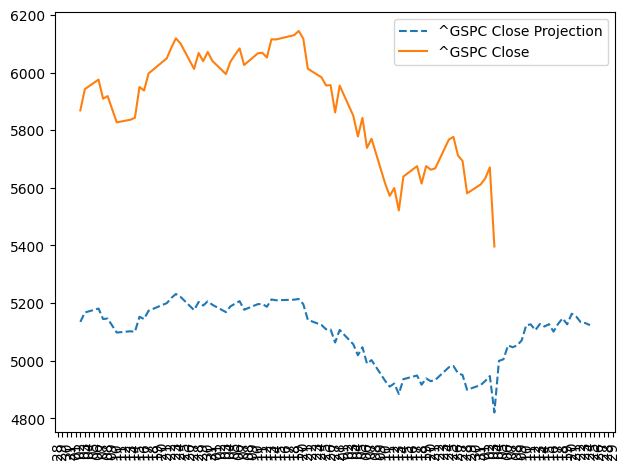

In [139]:
original_df['DATE'] = pd.to_datetime(original_df['DATE'])

plot_time_frame_year_x1(2025, 2025, original_df, unnorm_df, features_to_pred[0])